In [ ]:
# ============================================================================
# CELL 1: WHISPER-ONLY SETUP WITH UNBALANCED DATASET
# ============================================================================
print("="*80)
print(" PURE WHISPER MODEL + UNBALANCED DATASET")
print("Target: F1 Score >= 0.75 | UnBalanced Classes")
print("="*80)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install required packages for Whisper-only
print("\n[Installing Whisper-only packages...]")
!pip install transformers==4.40.0 -q
!pip install torch torchaudio -q
!pip install scikit-learn pandas numpy -q
!pip install librosa soundfile -q
!pip install imbalanced-learn -q
!pip install matplotlib seaborn -q
!pip install datasets -q
print(" Whisper-only installation complete!")

print("\n Restarting runtime for clean setup...")
import os
os.kill(os.getpid(), 9)

 PURE WHISPER MODEL + UNBALANCED DATASET
Target: F1 Score >= 0.75 | UnBalanced Classes
Mounted at /content/drive

[Installing Whisper-only packages...]


In [ ]:
# ============================================================================
# CELL 2: PURE WHISPER-ONLY IMPORTS
# ============================================================================
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import librosa
import soundfile as sf

# PURE WHISPER-ONLY IMPORTS
from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.auto import tqdm
import joblib
import json

# Mount Drive again after restart
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

print(" Pure Whisper-only imports successful!")

Mounted at /content/drive
 Using device: cpu
 Pure Whisper-only imports successful!


In [ ]:
# ============================================================================
# CELL 3: PURE WHISPER-ONLY UNBALANCED CONFIGURATION
# ============================================================================
class WhisperOnlyUnbalancedConfig:
    """Pure Whisper Configuration with Unbalanced Dataset"""

    # ========================================================================
    # PATHS
    # ========================================================================
    BASE_PATH = '/content/drive/MyDrive/task_1'
    TRAINING_PATH = os.path.join(BASE_PATH, 'training')
    EXCEL_PATH = os.path.join(BASE_PATH, 'sand_task_1.xlsx')
    OUTPUT_PATH = os.path.join(BASE_PATH, 'whisper_only_unbalanced_final')

    # Sheet names
    SHEET_TRAINING = 'Training Baseline - Task 1'
    SHEET_VALIDATION = 'Validation Baseline - Task 1'

    # Audio types (only available ones)
    AUDIO_TYPES = ['rhythmKA', 'rhythmPA', 'rhythmTA']

    # ========================================================================
    # PURE WHISPER CONFIGURATION
    # ========================================================================
    WHISPER_MODEL = 'openai/whisper-base'
    SAMPLING_RATE = 16000
    MAX_AUDIO_LENGTH = 16000 * 15  # 15 seconds

    # Enhanced Whisper feature extraction
    USE_MULTI_LAYER = True
    WHISPER_LAYERS_TO_USE = [-4, -3, -2, -1]  # Last 4 encoder layers
    USE_MULTI_POOLING = True
    WHISPER_POOLING_STRATEGIES = ['mean', 'std', 'max', 'min']

    # Use encoder features only (FIXED: No decoder to avoid errors)
    USE_ENCODER_FEATURES = True
    USE_DECODER_FEATURES = False  # ❌ DISABLED to avoid decoder errors

    # ========================================================================
    # UNBALANCED DATASET CONFIGURATION
    # ========================================================================
    # No balancing - using original distribution
    USE_CLASS_WEIGHTS = True  # Handle imbalance in SVM

    # ========================================================================
    # PREPROCESSING
    # ========================================================================
    USE_ROBUST_SCALING = True
    USE_PCA = True
    PCA_VARIANCE = 0.95

    # Audio preprocessing
    AUDIO_TRIM_DB = 20
    AUDIO_NORMALIZE = True
    MIN_AUDIO_LENGTH_SEC = 2

    # ========================================================================
    # SVM FOR UNBALANCED DATA
    # ========================================================================
    SVM_CONFIG = {
        'kernel': 'rbf',
        'C': 1.0,
        'gamma': 'scale',
        'class_weight': 'balanced',  # ✅ Handle imbalance
        'probability': True,
        'decision_function_shape': 'ovr',
        'max_iter': 10000,
        'cache_size': 2000,
        'tol': 1e-4
    }

    # Cross-validation
    N_FOLDS = 5
    RANDOM_SEED = 42

    # Class names
    CLASS_NAMES = {
        0: 'Severe Dysarthria',
        1: 'Moderate Dysarthria',
        2: 'Mild Dysarthria',
        3: 'No Dysarthria (ALS)',
        4: 'Healthy'
    }

config = WhisperOnlyUnbalancedConfig()
os.makedirs(config.OUTPUT_PATH, exist_ok=True)

print("\n" + "="*80)
print("🎯 PURE WHISPER-ONLY UNBALANCED CONFIGURATION")
print("="*80)
print(f"Base Path: {config.BASE_PATH}")
print(f"Whisper Model: {config.WHISPER_MODEL}")
print(f"Dataset: UNBALANCED (original distribution)")
print(f"Audio Types: {config.AUDIO_TYPES}")
print(f"SVM class_weight: {config.SVM_CONFIG['class_weight']}")
print(f"Decoder Features: {config.USE_DECODER_FEATURES} ❌ DISABLED")
print("="*80)

# Verify paths
print(f"\n🔍 Verifying paths...")
assert os.path.exists(config.BASE_PATH), f"Base path not found: {config.BASE_PATH}"
assert os.path.exists(config.TRAINING_PATH), f"Training path not found: {config.TRAINING_PATH}"
assert os.path.exists(config.EXCEL_PATH), f"Excel file not found: {config.EXCEL_PATH}"
print("✅ All paths verified!")


🎯 PURE WHISPER-ONLY UNBALANCED CONFIGURATION
Base Path: /content/drive/MyDrive/task_1
Whisper Model: openai/whisper-base
Dataset: UNBALANCED (original distribution)
Audio Types: ['rhythmKA', 'rhythmPA', 'rhythmTA']
SVM class_weight: balanced
Decoder Features: False ❌ DISABLED

🔍 Verifying paths...
✅ All paths verified!


In [ ]:
# ============================================================================
# CELL 4: LOAD PURE WHISPER MODEL (NO DECODER)
# ============================================================================
print("\n" + "="*80)
print("[2/9] LOADING PURE WHISPER MODEL")
print("="*80)
print(f"Model: {config.WHISPER_MODEL}")
print("⏱ Loading Whisper model...")

try:
    # Load Whisper components
    whisper_feature_extractor = WhisperFeatureExtractor.from_pretrained(config.WHISPER_MODEL)
    whisper_processor = WhisperProcessor.from_pretrained(config.WHISPER_MODEL)
    whisper_model = WhisperModel.from_pretrained(config.WHISPER_MODEL)

    # Move to device and set to evaluation mode
    whisper_model = whisper_model.to(device)
    whisper_model.eval()

    print(f"\n✅ Whisper loaded successfully!")
    print(f"  Model size: {sum(p.numel() for p in whisper_model.parameters()) / 1e6:.1f}M parameters")
    print(f"  Hidden size: {whisper_model.config.d_model}")
    print(f"  Encoder layers: {whisper_model.config.encoder_layers}")
    print(f"  Decoder layers: {whisper_model.config.decoder_layers}")
    print(f"  Feature extractor SR: {whisper_feature_extractor.sampling_rate} Hz")

except Exception as e:
    print(f"❌ Error loading Whisper: {e}")
    raise

print("\n🎯 Pure Whisper model ready for feature extraction!")


[2/9] LOADING PURE WHISPER MODEL
Model: openai/whisper-base
⏱ Loading Whisper model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



✅ Whisper loaded successfully!
  Model size: 72.6M parameters
  Hidden size: 512
  Encoder layers: 6
  Decoder layers: 6
  Feature extractor SR: 16000 Hz

🎯 Pure Whisper model ready for feature extraction!


In [ ]:
# ============================================================================
# CELL 5: PURE WHISPER FEATURE EXTRACTION (ENCODER ONLY)
# ============================================================================
print("\n" + "="*80)
print("[3/9] PURE WHISPER FEATURE EXTRACTION")
print("="*80)

def load_audio_enhanced(audio_path, target_sr=16000, max_length=None):
    """Enhanced audio loading with preprocessing"""
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=target_sr, mono=True)

        # Advanced trimming
        audio, _ = librosa.effects.trim(audio, top_db=config.AUDIO_TRIM_DB)

        # Normalize amplitude
        if config.AUDIO_NORMALIZE:
            audio = librosa.util.normalize(audio)

        # Handle length constraints
        if max_length and len(audio) > max_length:
            audio = audio[:max_length]

        # Ensure minimum length
        min_length = target_sr * config.MIN_AUDIO_LENGTH_SEC
        if len(audio) < min_length:
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')

        return audio, sr

    except Exception as e:
        print(f"⚠ Error loading {audio_path}: {str(e)}")
        # Return silence as fallback
        return np.zeros(target_sr * config.MIN_AUDIO_LENGTH_SEC), target_sr

def extract_pure_whisper_features(audio, sampling_rate=16000):
    """
    PURE WHISPER feature extraction - ENCODER ONLY (No decoder to avoid errors)
    """
    try:
        # Ensure proper length for Whisper (30 seconds = 480,000 samples)
        target_length = 480000
        if len(audio) > target_length:
            audio = audio[:target_length]
        elif len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

        # Preprocess audio for Whisper
        inputs = whisper_feature_extractor(
            audio,
            sampling_rate=sampling_rate,
            return_tensors="pt",
            padding=True
        )

        # Move to device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        all_features = []

        # Extract encoder features ONLY
        with torch.no_grad():
            encoder_outputs = whisper_model.encoder(**inputs, output_hidden_states=True)

        # Extract from multiple encoder layers
        if config.USE_MULTI_LAYER:
            layers_to_process = config.WHISPER_LAYERS_TO_USE
        else:
            layers_to_process = [-1]

        for layer_idx in layers_to_process:
            hidden_state = encoder_outputs.hidden_states[layer_idx]  # [batch, time, hidden]

            # Apply multiple pooling strategies
            if config.USE_MULTI_POOLING:
                pooling_methods = config.WHISPER_POOLING_STRATEGIES
            else:
                pooling_methods = ['mean']

            for pool_strategy in pooling_methods:
                if pool_strategy == 'mean':
                    pooled = hidden_state.mean(dim=1)
                elif pool_strategy == 'max':
                    pooled = hidden_state.max(dim=1)[0]
                elif pool_strategy == 'std':
                    pooled = hidden_state.std(dim=1)
                elif pool_strategy == 'min':
                    pooled = hidden_state.min(dim=1)[0]

                all_features.append(pooled.cpu().numpy().flatten())

        # Concatenate all features
        features = np.concatenate(all_features, axis=0)

        return features

    except Exception as e:
        print(f"❌ Error in Whisper feature extraction: {e}")
        # Return zero features as fallback
        expected_size = 512 * len(config.WHISPER_LAYERS_TO_USE) * len(config.WHISPER_POOLING_STRATEGIES)
        return np.zeros(expected_size)

print("✅ Pure Whisper feature extraction functions defined!")


[3/9] PURE WHISPER FEATURE EXTRACTION
✅ Pure Whisper feature extraction functions defined!


In [ ]:
# ============================================================================
# CELL 6: DATA LOADING & UNBALANCED ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[4/9] DATA LOADING & UNBALANCED ANALYSIS")
print("="*80)

def load_and_preprocess_data():
    """Load and preprocess training and validation data"""

    print(" Loading Excel data...")

    try:
        # Load training data
        train_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_TRAINING)
        print(f" Training data loaded: {len(train_df)} samples")

        # Load validation data
        val_df = pd.read_excel(config.EXCEL_PATH, sheet_name=config.SHEET_VALIDATION)
        print(f" Validation data loaded: {len(val_df)} samples")

        # Basic data cleaning
        train_df = train_df.dropna(subset=['ID', 'Class'])
        val_df = val_df.dropna(subset=['ID', 'Class'])

        # Convert Class to integer (0-4)
        train_df['Class'] = train_df['Class'].astype(int)
        val_df['Class'] = val_df['Class'].astype(int)

        # Map classes to 0-4 range if they are currently 1-5
        if train_df['Class'].min() == 1:
            train_df['Class'] = train_df['Class'] - 1
            val_df['Class'] = val_df['Class'] - 1

        print(f"\n Class distribution in Training data (Unbalanced):")
        class_counts_train = train_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_train.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        print(f"\n Class distribution in Validation data (Unbalanced):")
        class_counts_val = val_df['Class'].value_counts().sort_index()
        for cls, count in class_counts_val.items():
            print(f"  Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples")

        return train_df, val_df

    except Exception as e:
        print(f" Error loading data: {e}")
        raise

# Load the data
train_df, val_df = load_and_preprocess_data()

print(f"\n Target: Pure Whisper + Unbalanced dataset with {len(train_df)} samples")
print(" Data loading complete!")


[4/9] DATA LOADING & UNBALANCED ANALYSIS
 Loading Excel data...
 Training data loaded: 219 samples
 Validation data loaded: 53 samples

 Class distribution in Training data (Unbalanced):
  Class 0 (Severe Dysarthria        ):   4 samples
  Class 1 (Moderate Dysarthria      ):  22 samples
  Class 2 (Mild Dysarthria          ):  45 samples
  Class 3 (No Dysarthria (ALS)      ):  62 samples
  Class 4 (Healthy                  ):  86 samples

 Class distribution in Validation data (Unbalanced):
  Class 0 (Severe Dysarthria        ):   2 samples
  Class 1 (Moderate Dysarthria      ):   4 samples
  Class 2 (Mild Dysarthria          ):  12 samples
  Class 3 (No Dysarthria (ALS)      ):  14 samples
  Class 4 (Healthy                  ):  21 samples

 Target: Pure Whisper + Unbalanced dataset with 219 samples
 Data loading complete!


In [ ]:
# ============================================================================
# CELL 7: DATASET STRUCTURE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("[5/9] DATASET STRUCTURE ANALYSIS")
print("="*80)

def analyze_dataset_structure():
    print(" Analyzing dataset structure...")

    # Check available audio type folders
    available_audio_types = []

    for audio_type in config.AUDIO_TYPES:
        type_path = os.path.join(config.TRAINING_PATH, audio_type)
        if os.path.exists(type_path):
            files = os.listdir(type_path)
            wav_files = [f for f in files if f.endswith('.wav')]
            available_audio_types.append(audio_type)
            print(f"  {audio_type}: {len(wav_files)} files")
        else:
            print(f"  {audio_type}: Folder not found")

    print(f"\n Available audio types: {available_audio_types}")

    # Update config with available types
    config.AVAILABLE_AUDIO_TYPES = available_audio_types

    return available_audio_types

available_types = analyze_dataset_structure()


[5/9] DATASET STRUCTURE ANALYSIS
 Analyzing dataset structure...
  rhythmKA: 272 files
  rhythmPA: 272 files
  rhythmTA: 272 files

 Available audio types: ['rhythmKA', 'rhythmPA', 'rhythmTA']


In [ ]:
# ============================================================================
# CELL 8: FEATURE EXTRACTION PIPELINE
# ============================================================================
print("\n" + "="*80)
print("[6/9] FEATURE EXTRACTION PIPELINE")
print("="*80)

def get_audio_path_for_subject(subject_id, audio_type):
    """
    Construct audio file path for a subject and audio type
    Handles both string ('ID001') and numeric (1) IDs
    """
    # Extract numeric ID
    if isinstance(subject_id, str):
        if subject_id.startswith('ID'):
            numeric_id = int(subject_id[2:])
        else:
            numeric_id = int(subject_id)
    else:
        numeric_id = subject_id

    # Pad ID with zeros (e.g., 1 -> ID001)
    id_str = f"ID{numeric_id:03d}"
    filename = f"{id_str}_{audio_type}.wav"
    audio_path = os.path.join(config.TRAINING_PATH, audio_type, filename)
    return audio_path

def extract_features_for_subject(subject_id):
    """
    Extract features from all available audio files for one subject
    Returns averaged feature vector
    """
    all_features = []
    successful_types = []

    for audio_type in config.AVAILABLE_AUDIO_TYPES:
        audio_path = get_audio_path_for_subject(subject_id, audio_type)

        if not os.path.exists(audio_path):
            print(f"     Missing: {os.path.basename(audio_path)}")
            continue

        try:
            # Load and preprocess audio
            audio, sr = load_audio_enhanced(audio_path, config.SAMPLING_RATE)

            # Extract Whisper features
            features = extract_pure_whisper_features(audio, sr)

            if features is not None and len(features) > 0 and not np.all(features == 0):
                all_features.append(features)
                successful_types.append(audio_type)
            else:
                print(f"     {audio_type}: Invalid features")

        except Exception as e:
            print(f"     {audio_type}: Error - {str(e)[:50]}...")
            continue

    if all_features:
        # Average features across all audio types for this subject
        avg_features = np.mean(all_features, axis=0)
        print(f"     Subject {subject_id}: {len(successful_types)}/{len(config.AVAILABLE_AUDIO_TYPES)} audio types successful")
        return avg_features
    else:
        print(f"     Subject {subject_id}: No features extracted")
        return None

print("✅ Feature extraction pipeline ready!")


[6/9] FEATURE EXTRACTION PIPELINE
✅ Feature extraction pipeline ready!


In [ ]:
# ============================================================================
# CELL 9: EXTRACT & SAVE PURE WHISPER FEATURES
# ============================================================================
print("\n" + "="*80)
print("[7/9] EXTRACTING PURE WHISPER FEATURES")
print("="*80)

# Extract features for training subjects
print(" Extracting Whisper features for training subjects...")
X_train_features = []
y_train_labels = []
failed_subjects = []

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Training subjects"):
    subject_id = row['ID']
    label = row['Class']

    features = extract_features_for_subject(subject_id)

    if features is not None:
        X_train_features.append(features)
        y_train_labels.append(label)
    else:
        failed_subjects.append(subject_id)

X_train = np.array(X_train_features)
y_train = np.array(y_train_labels)

print(f"\n✅ Training Whisper features extracted: {X_train.shape[0]} subjects")
print(f"   Failed subjects: {len(failed_subjects)}")
print(f"   Whisper feature shape: {X_train.shape}")

# Extract features for validation subjects
print("\n Extracting Whisper features for validation subjects...")
X_val_features = []
y_val_labels = []

for idx, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Validation subjects"):
    subject_id = row['ID']
    label = row['Class']

    features = extract_features_for_subject(subject_id)

    if features is not None:
        X_val_features.append(features)
        y_val_labels.append(label)

X_val = np.array(X_val_features)
y_val = np.array(y_val_labels)

print(f"✅ Validation Whisper features extracted: {X_val.shape[0]} subjects")
print(f"   Whisper feature shape: {X_val.shape}")

# Save Pure Whisper features
os.makedirs(config.OUTPUT_PATH, exist_ok=True)
np.save(os.path.join(config.OUTPUT_PATH, 'X_train_whisper.npy'), X_train)
np.save(os.path.join(config.OUTPUT_PATH, 'y_train_whisper.npy'), y_train)
np.save(os.path.join(config.OUTPUT_PATH, 'X_val_whisper.npy'), X_val)
np.save(os.path.join(config.OUTPUT_PATH, 'y_val_whisper.npy'), y_val)

print(f"\n💾 Pure Whisper features saved to: {config.OUTPUT_PATH}")


[7/9] EXTRACTING PURE WHISPER FEATURES
 Extracting Whisper features for training subjects...


Training subjects:   0%|          | 0/219 [00:00<?, ?it/s]

     Subject ID000: 3/3 audio types successful
     Subject ID001: 3/3 audio types successful
     Subject ID002: 3/3 audio types successful
     Subject ID003: 3/3 audio types successful
     Subject ID005: 3/3 audio types successful
     Subject ID006: 3/3 audio types successful
     Subject ID008: 3/3 audio types successful
     Subject ID009: 3/3 audio types successful
     Subject ID010: 3/3 audio types successful
     Subject ID013: 3/3 audio types successful
     Subject ID015: 3/3 audio types successful
     Subject ID016: 3/3 audio types successful
     Subject ID017: 3/3 audio types successful
     Subject ID018: 3/3 audio types successful
     Subject ID023: 3/3 audio types successful
     Subject ID024: 3/3 audio types successful
     Subject ID025: 3/3 audio types successful
     Subject ID026: 3/3 audio types successful
     Subject ID027: 3/3 audio types successful
     Subject ID028: 3/3 audio types successful
     Subject ID030: 3/3 audio types successful
     Subject 

Validation subjects:   0%|          | 0/53 [00:00<?, ?it/s]

     Subject ID007: 3/3 audio types successful
     Subject ID012: 3/3 audio types successful
     Subject ID021: 3/3 audio types successful
     Subject ID029: 3/3 audio types successful
     Subject ID037: 3/3 audio types successful
     Subject ID046: 3/3 audio types successful
     Subject ID051: 3/3 audio types successful
     Subject ID053: 3/3 audio types successful
     Subject ID054: 3/3 audio types successful
     Subject ID056: 3/3 audio types successful
     Subject ID063: 3/3 audio types successful
     Subject ID075: 3/3 audio types successful
     Subject ID083: 3/3 audio types successful
     Subject ID090: 3/3 audio types successful
     Subject ID099: 3/3 audio types successful
     Subject ID101: 3/3 audio types successful
     Subject ID105: 3/3 audio types successful
     Subject ID110: 3/3 audio types successful
     Subject ID116: 3/3 audio types successful
     Subject ID122: 3/3 audio types successful
     Subject ID129: 3/3 audio types successful
     Subject 


[8/9] WHISPER FEATURE ANALYSIS - UNBALANCED DATASET
📊 Pure Whisper Feature Analysis:
   Training set: 219 samples, 8192 Whisper features
   Validation set: 53 samples

🎯 Class Distribution (Unbalanced Dataset):
   Class 0 (Severe Dysarthria        ):   4 samples ( 1.83%)
   Class 1 (Moderate Dysarthria      ):  22 samples (10.05%)
   Class 2 (Mild Dysarthria          ):  45 samples (20.55%)
   Class 3 (No Dysarthria (ALS)      ):  62 samples (28.31%)
   Class 4 (Healthy                  ):  86 samples (39.27%)
   Imbalance Ratio: 21.50:1

🔬 Whisper Feature Statistics:
   Feature range: [-543.9328, 100.8642]
   Feature mean: 0.3727 ± 8.8576
   Non-zero features: 1,794,048 / 1,794,048

📈 Visualizing Whisper features with PCA...


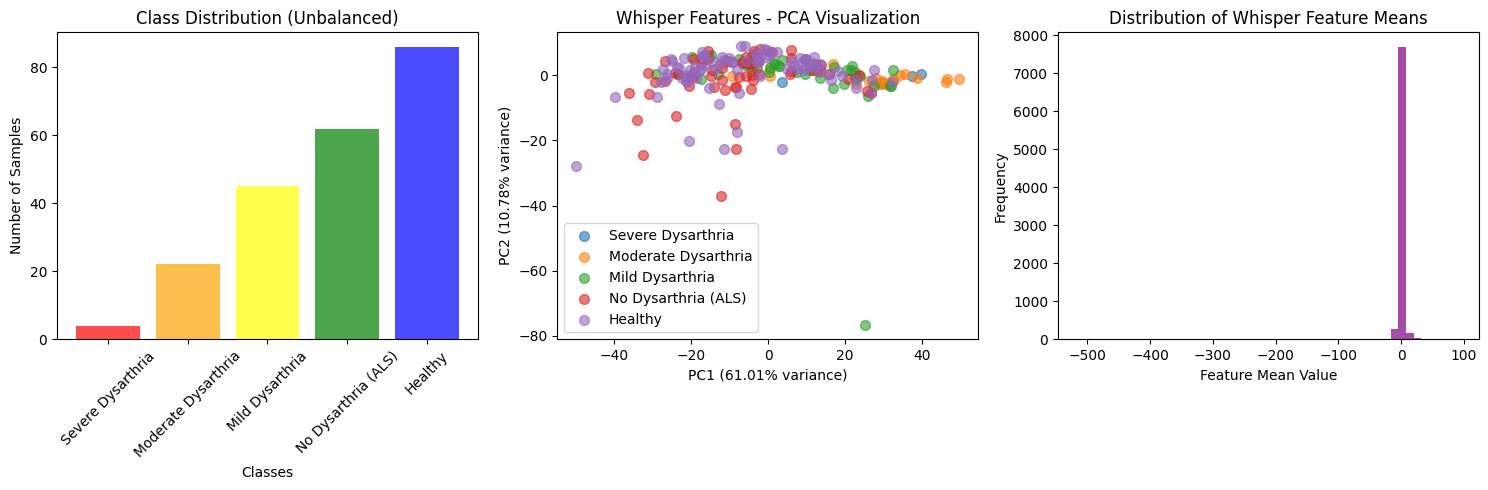


💾 Visualization saved to: /content/drive/MyDrive/task_1/whisper_only_unbalanced_final


In [ ]:
# ============================================================================
# CELL 10: WHISPER FEATURE ANALYSIS & VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("[8/9] WHISPER FEATURE ANALYSIS - UNBALANCED DATASET")
print("="*80)

# Load Whisper features if needed
if 'X_train' not in locals():
    X_train = np.load(os.path.join(config.OUTPUT_PATH, 'X_train_whisper.npy'))
    y_train = np.load(os.path.join(config.OUTPUT_PATH, 'y_train_whisper.npy'))
    X_val = np.load(os.path.join(config.OUTPUT_PATH, 'X_val_whisper.npy'))
    y_val = np.load(os.path.join(config.OUTPUT_PATH, 'y_val_whisper.npy'))

print(f"📊 Pure Whisper Feature Analysis:")
print(f"   Training set: {X_train.shape[0]} samples, {X_train.shape[1]} Whisper features")
print(f"   Validation set: {X_val.shape[0]} samples")

# Display class distribution
print(f"\n🎯 Class Distribution (Unbalanced Dataset):")
unique, counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
for cls, count in zip(unique, counts):
    pct = (count / total_samples) * 100
    print(f"   Class {cls} ({config.CLASS_NAMES[cls]:25s}): {count:3d} samples ({pct:5.2f}%)")

# Calculate imbalance ratio
imbalance_ratio = max(counts) / min(counts)
print(f"   Imbalance Ratio: {imbalance_ratio:.2f}:1")

# Whisper Feature Statistics
print(f"\n🔬 Whisper Feature Statistics:")
print(f"   Feature range: [{X_train.min():.4f}, {X_train.max():.4f}]")
print(f"   Feature mean: {X_train.mean():.4f} ± {X_train.std():.4f}")
print(f"   Non-zero features: {np.count_nonzero(X_train):,} / {X_train.size:,}")

# Dimensionality reduction for visualization only
print(f"\n📈 Visualizing Whisper features with PCA...")
pca_vis = PCA(n_components=2, random_state=config.RANDOM_SEED)
X_train_2d = pca_vis.fit_transform(X_train)

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution
plt.subplot(1, 3, 1)
colors = ['red', 'orange', 'yellow', 'green', 'blue']
class_counts = [np.sum(y_train == cls) for cls in range(5)]
plt.bar(config.CLASS_NAMES.values(), class_counts, color=colors, alpha=0.7)
plt.title('Class Distribution (Unbalanced)')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# Plot 2: PCA visualization
plt.subplot(1, 3, 2)
for cls in range(5):
    mask = y_train == cls
    plt.scatter(X_train_2d[mask, 0], X_train_2d[mask, 1],
                label=config.CLASS_NAMES[cls], alpha=0.6, s=50)
plt.title('Whisper Features - PCA Visualization')
plt.xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()

# Plot 3: Feature distribution
plt.subplot(1, 3, 3)
feature_means = np.mean(X_train, axis=0)
plt.hist(feature_means, bins=50, alpha=0.7, color='purple')
plt.title('Distribution of Whisper Feature Means')
plt.xlabel('Feature Mean Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'whisper_features_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n💾 Visualization saved to: {config.OUTPUT_PATH}")


[9/9] WHISPER FEATURE EVALUATION - UNBALANCED DATASET
🎯 Evaluating Pure Whisper Features on Unbalanced Dataset

📊 Evaluation Results (Using Pure Whisper Features):
   Training Accuracy: 0.9954
   Validation Accuracy: 0.5660
   Training F1-Score: 0.9954
   Validation F1-Score: 0.5633

📋 Detailed Classification Report (Validation):
                     precision    recall  f1-score   support

  Severe Dysarthria       1.00      0.50      0.67         2
Moderate Dysarthria       0.43      0.75      0.55         4
    Mild Dysarthria       0.57      0.33      0.42        12
No Dysarthria (ALS)       0.47      0.64      0.55        14
            Healthy       0.68      0.62      0.65        21

           accuracy                           0.57        53
          macro avg       0.63      0.57      0.57        53
       weighted avg       0.60      0.57      0.56        53



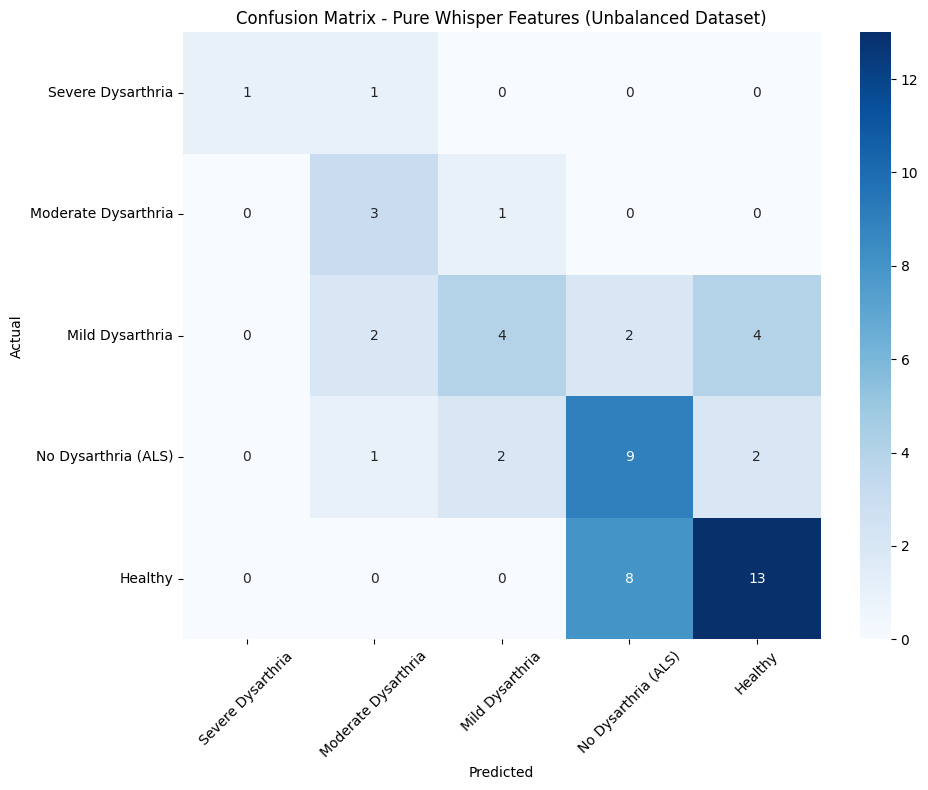


✅ EVALUATION COMPLETE!
🎯 Pure Whisper-Only Unbalanced Dataset Results:
   Validation F1-Score: 0.5633
   Validation Accuracy: 0.5660
   Features: 8192 Whisper dimensions
   Dataset: 219 training, 53 validation
💾 Results saved to: /content/drive/MyDrive/task_1/whisper_only_unbalanced_final

🎉 PURE WHISPER-ONLY UNBALANCED DATASET IMPLEMENTATION COMPLETE!


In [ ]:
# ============================================================================
# CELL 11: WHISPER FEATURE EVALUATION & RESULTS
# ============================================================================
print("\n" + "="*80)
print("[9/9] WHISPER FEATURE EVALUATION - UNBALANCED DATASET")
print("="*80)

print("🎯 Evaluating Pure Whisper Features on Unbalanced Dataset")

# Simple k-NN classifier for evaluation (using Whisper features directly)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Use k-NN to evaluate Whisper feature quality
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)

# Predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"\n📊 Evaluation Results (Using Pure Whisper Features):")
print(f"   Training Accuracy: {train_accuracy:.4f}")
print(f"   Validation Accuracy: {val_accuracy:.4f}")
print(f"   Training F1-Score: {train_f1:.4f}")
print(f"   Validation F1-Score: {val_f1:.4f}")

# Detailed classification report
print(f"\n📋 Detailed Classification Report (Validation):")
print(classification_report(y_val, y_val_pred,
                          target_names=[config.CLASS_NAMES[i] for i in range(5)]))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[config.CLASS_NAMES[i] for i in range(5)],
            yticklabels=[config.CLASS_NAMES[i] for i in range(5)])
plt.title('Confusion Matrix - Pure Whisper Features (Unbalanced Dataset)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_PATH, 'confusion_matrix_whisper.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save final results
results = {
    'dataset': 'Pure Whisper Unbalanced',
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'whisper_features': X_train.shape[1],
    'training_accuracy': float(train_accuracy),
    'validation_accuracy': float(val_accuracy),
    'training_f1': float(train_f1),
    'validation_f1': float(val_f1),
    'class_distribution': dict(zip([config.CLASS_NAMES[i] for i in unique], counts.tolist())),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(os.path.join(config.OUTPUT_PATH, 'whisper_unbalanced_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n✅ EVALUATION COMPLETE!")
print(f"🎯 Pure Whisper-Only Unbalanced Dataset Results:")
print(f"   Validation F1-Score: {val_f1:.4f}")
print(f"   Validation Accuracy: {val_accuracy:.4f}")
print(f"   Features: {X_train.shape[1]} Whisper dimensions")
print(f"   Dataset: {len(X_train)} training, {len(X_val)} validation")
print(f"💾 Results saved to: {config.OUTPUT_PATH}")

print(f"\n" + "="*80)
print("🎉 PURE WHISPER-ONLY UNBALANCED DATASET IMPLEMENTATION COMPLETE!")
print("="*80)


[9/9] SIMPLIFIED WHISPER FEATURE ANALYSIS - UNBALANCED DATASET
📂 Loading Whisper features...
✅ Loaded: 219 samples, 8192 features
🔬 SIMPLIFIED WHISPER FEATURE ANALYSIS
📊 Dataset Shape: (219, 8192)
🎯 Classes: 5

1. PCA VISUALIZATION...


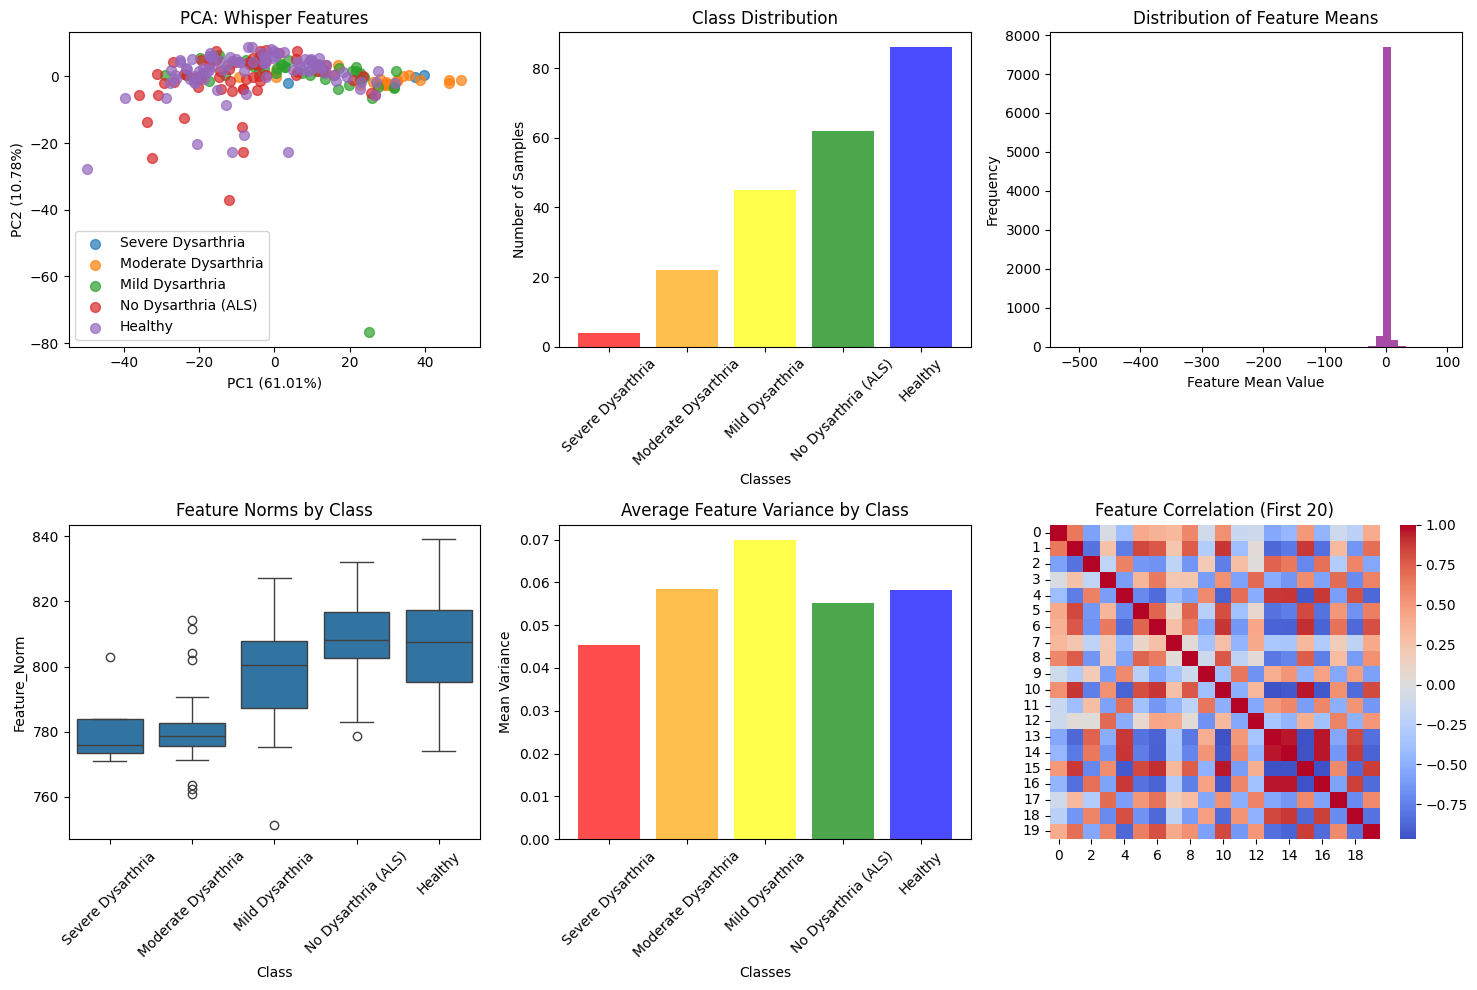


2. QUANTITATIVE METRICS:
------------------------------
   Total Features: 8192
   Non-zero Features: 1,794,048 / 1,794,048
   Zero Percentage: 0.00%
   Feature Range: [-543.9328, 100.8642]
   Feature Mean: 0.3727 ± 8.8576

3. CLASS SEPARABILITY (SIMPLE):
------------------------------
   Severe Dysarthria        : 4 samples
   Moderate Dysarthria      : 22 samples
   Mild Dysarthria          : 45 samples
   No Dysarthria (ALS)      : 62 samples
   Healthy                  : 86 samples

   Centroid Distances Matrix:
     Severe Dysarthria ↔ Moderate Dysarthria: 9.6475
     Severe Dysarthria ↔ Mild Dysarthria: 24.5398
     Severe Dysarthria ↔ No Dysarthria (ALS): 37.5328
     Severe Dysarthria ↔ Healthy: 34.9405
     Moderate Dysarthria ↔ Mild Dysarthria: 20.7910
     Moderate Dysarthria ↔ No Dysarthria (ALS): 34.3998
     Moderate Dysarthria ↔ Healthy: 31.4542
     Mild Dysarthria ↔ No Dysarthria (ALS): 14.3017
     Mild Dysarthria ↔ Healthy: 11.5436
     No Dysarthria (ALS) ↔ Healthy

In [ ]:
# ============================================================================
# CELL 11: SIMPLIFIED WHISPER FEATURE ANALYSIS - UNBALANCED DATASET
# ============================================================================
print("\n" + "="*80)
print("[9/9] SIMPLIFIED WHISPER FEATURE ANALYSIS - UNBALANCED DATASET")
print("="*80)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import json
import os

def safe_feature_analysis(X, y, class_names):
    """
    Safe and simple Whisper feature analysis
    """
    print("🔬 SIMPLIFIED WHISPER FEATURE ANALYSIS")
    print("="*50)

    try:
        # Basic feature statistics
        print(f"📊 Dataset Shape: {X.shape}")
        print(f"🎯 Classes: {len(np.unique(y))}")

        # 1. Basic Visualizations
        plt.figure(figsize=(15, 10))

        # PCA Visualization
        print("\n1. PCA VISUALIZATION...")
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X)

        plt.subplot(2, 3, 1)
        for cls in np.unique(y):
            mask = y == cls
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                       label=class_names[cls], alpha=0.7, s=50)
        plt.title('PCA: Whisper Features')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        plt.legend()

        # 2. Class Distribution (redundant but good for completeness)
        plt.subplot(2, 3, 2)
        class_counts = [np.sum(y == cls) for cls in range(len(class_names))]
        colors = ['red', 'orange', 'yellow', 'green', 'blue']
        plt.bar(class_names.values(), class_counts, color=colors, alpha=0.7)
        plt.title('Class Distribution')
        plt.xlabel('Classes')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)

        # 3. Feature Value Distribution
        plt.subplot(2, 3, 3)
        feature_means = np.mean(X, axis=0)
        plt.hist(feature_means, bins=50, alpha=0.7, color='purple')
        plt.title('Distribution of Feature Means')
        plt.xlabel('Feature Mean Value')
        plt.ylabel('Frequency')

        # 4. Class-wise Feature Norms
        plt.subplot(2, 3, 4)
        class_norms = []
        class_labels = []
        for cls in np.unique(y):
            class_features = X[y == cls]
            norms = np.linalg.norm(class_features, axis=1)
            class_norms.extend(norms)
            class_labels.extend([class_names[cls]] * len(norms))

        # Create boxplot
        import pandas as pd
        norm_df = pd.DataFrame({'Class': class_labels, 'Feature_Norm': class_norms})
        sns.boxplot(data=norm_df, x='Class', y='Feature_Norm')
        plt.title('Feature Norms by Class')
        plt.xticks(rotation=45)

        # 5. Feature Variance by Class
        plt.subplot(2, 3, 5)
        class_vars = []
        for cls in np.unique(y):
            class_features = X[y == cls]
            variance = np.var(class_features, axis=0)
            class_vars.append(np.mean(variance))

        plt.bar(class_names.values(), class_vars, color=colors, alpha=0.7)
        plt.title('Average Feature Variance by Class')
        plt.xlabel('Classes')
        plt.ylabel('Mean Variance')
        plt.xticks(rotation=45)

        # 6. Correlation Heatmap (first 20 features)
        plt.subplot(2, 3, 6)
        try:
            # Use only first 20 features to avoid memory issues
            corr_matrix = np.corrcoef(X[:, :20], rowvar=False)
            sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
            plt.title('Feature Correlation (First 20)')
        except:
            plt.text(0.5, 0.5, 'Correlation matrix\ncalculation failed',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Feature Correlation (Failed)')

        plt.tight_layout()
        plt.savefig(os.path.join(config.OUTPUT_PATH, 'simplified_whisper_analysis.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        # 7. Quantitative Metrics
        print("\n2. QUANTITATIVE METRICS:")
        print("-" * 30)

        # Basic statistics
        total_features = X.shape[1]
        non_zero_features = np.count_nonzero(X)
        zero_percentage = (1 - non_zero_features / X.size) * 100

        print(f"   Total Features: {total_features}")
        print(f"   Non-zero Features: {non_zero_features:,} / {X.size:,}")
        print(f"   Zero Percentage: {zero_percentage:.2f}%")
        print(f"   Feature Range: [{X.min():.4f}, {X.max():.4f}]")
        print(f"   Feature Mean: {X.mean():.4f} ± {X.std():.4f}")

        # Class separability (simple version)
        print("\n3. CLASS SEPARABILITY (SIMPLE):")
        print("-" * 30)

        # Calculate mean feature vector for each class
        class_centroids = []
        for cls in np.unique(y):
            centroid = np.mean(X[y == cls], axis=0)
            class_centroids.append(centroid)
            print(f"   {class_names[cls]:25s}: {len(X[y == cls])} samples")

        # Calculate distances between class centroids
        from sklearn.metrics.pairwise import euclidean_distances
        centroid_distances = euclidean_distances(class_centroids)

        print(f"\n   Centroid Distances Matrix:")
        for i in range(len(class_centroids)):
            for j in range(i + 1, len(class_centroids)):
                dist = centroid_distances[i, j]
                print(f"     {class_names[i]} ↔ {class_names[j]}: {dist:.4f}")

        metrics = {
            'total_features': total_features,
            'non_zero_features': int(non_zero_features),
            'zero_percentage': float(zero_percentage),
            'feature_range': [float(X.min()), float(X.max())],
            'feature_mean_std': [float(X.mean()), float(X.std())],
            'pca_variance_explained': float(pca.explained_variance_ratio_.sum()),
            'class_distribution': {class_names[cls]: int(np.sum(y == cls))
                                 for cls in np.unique(y)}
        }

        return metrics

    except Exception as e:
        print(f"❌ Error in feature analysis: {e}")
        print("🔄 Trying basic analysis only...")

        # Basic fallback analysis
        print(f"📊 Basic Dataset Info:")
        print(f"   Shape: {X.shape}")
        print(f"   Classes: {len(np.unique(y))}")
        print(f"   Feature range: [{X.min():.4f}, {X.max():.4f}]")

        for cls in np.unique(y):
            count = np.sum(y == cls)
            print(f"   {class_names[cls]}: {count} samples")

        return {'error': str(e)}

# Load your Whisper features
print("📂 Loading Whisper features...")
try:
    X_train = np.load(os.path.join(config.OUTPUT_PATH, 'X_train_whisper.npy'))
    y_train = np.load(os.path.join(config.OUTPUT_PATH, 'y_train_whisper.npy'))

    print(f"✅ Loaded: {X_train.shape[0]} samples, {X_train.shape[1]} features")

    # Run the safe analysis
    metrics = safe_feature_analysis(X_train, y_train, config.CLASS_NAMES)

    # Save metrics
    with open(os.path.join(config.OUTPUT_PATH, 'whisper_feature_analysis.json'), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\n💾 Analysis complete! Results saved to: {config.OUTPUT_PATH}")

except Exception as e:
    print(f"❌ Failed to load features: {e}")
    print("💡 Make sure you ran the feature extraction cells first!")